In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import MetaTrainer, ParameterEstimationTrainer
from bayesflow.networks import SequenceNet, EvidentialNetwork, InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import MetaAmortizer, SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.diagnostics import true_vs_estimated

from generative_models import batch_generate_levy_lca, generate_levy_lca

from meta_aux_classes import *

import warnings
warnings.filterwarnings('ignore')

%load_ext Cython

In [2]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

In [3]:
class LCAPrior:
    def __init__(self, n_conditions=2, n_accumulators=2):
        self.n_conditions = n_conditions
        self.n_accumulators = n_accumulators
    
    def __call__(self, batch_size):
        p = np.random.uniform(0.5, 2.00, size=(batch_size, self.n_conditions * self.n_accumulators)).astype('double')
        a = np.random.uniform(0.5, 1.5, size=batch_size).astype('double')        
        beta = np.random.uniform(0.1, 0.9, size=batch_size).astype('double')
        kappa = np.random.uniform(0.1, 0.9, size=batch_size).astype('double')
        ndt = np.random.uniform(0.2, 0.5, size=batch_size).astype('double')
        # alpha = np.random.uniform(1.0, 2.0, size=batch_size).astype('double')
        
        params = np.column_stack((p, a, beta, kappa, ndt))
        return params
    

class LCASimulator:
    def __init__(self, n_conditions=2, n_accumulators=2, s=0.1):
        self.n_conditions = n_conditions
        self.n_accumulators = n_accumulators
        self.s = s  # noise
    
    @staticmethod
    def partition(n, c):
        """Partitions the integer n into c equally sized chunks and returns an c-lengthed array of chunk sizes."""
        return [n // c + (1 if x < n % c else 0)
                      for x in range (c)]
        
    def __call__(self, params, n_obs):
        n_sim = params.shape[0]
        
        # total number of drift rates = n_cond * n_acc
        n_p = self.n_conditions * self.n_accumulators
        
        # Split n_obs equally between conditions 
        n_obs_cond = self.partition(n_obs, self.n_conditions)

        # Shared parameters
        a, beta, kappa, ndt = tuple(params.T[n_p:])
        alpha = np.full_like(a, 2.0, dtype='double')   # Levy alpha-stable parameter
        
        # Individual parameters per cond and accumulator: p, x_acc
        p_cond = params[:, :n_p].reshape((n_sim, self.n_accumulators, self.n_conditions))
        x_acc = np.zeros_like(p_cond, dtype='double')
        
        # initialize sim_data array
        sim_data = np.empty((n_sim, n_obs), dtype=np.float32)
        
        # indexing along n_obs dimension
        start_idx = end_idx = 0
        for c in range(self.n_conditions):
            start_idx, end_idx = end_idx, end_idx + n_obs_cond[c]  # increment by current n_obs_cond
            cond_data = batch_generate_levy_lca(n_obs_cond[c], 
                                                p_cond[:, :, c], x_acc[:, :, c],  # individual 
                                                kappa, beta, a, ndt, alpha, self.s)       # shared
            sim_data[:, start_idx:end_idx] = np.array(cond_data, dtype=np.float32)
        
        cond_row = np.concatenate([n_obs_cond[c] * [c] for c in range(self.n_conditions)])
        cond_arr = np.stack(n_sim * [cond_row])
        sim_data = np.stack((sim_data, cond_arr), axis=-1)
        
        return sim_data

Accuracy: 98.10%
Drift rates: 1.667, 0.588
Other params: a=0.951, kappa=0.228, beta=0.478, ndt=0.401


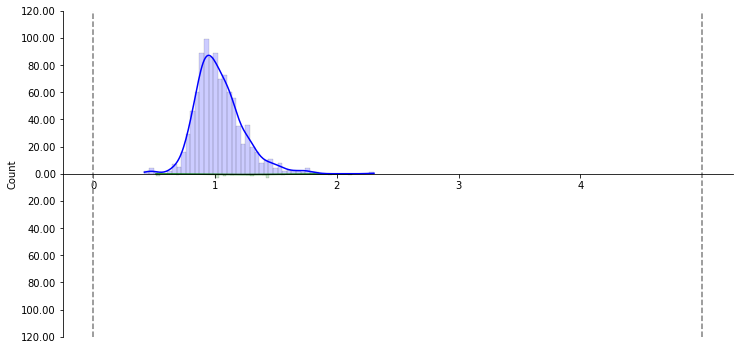

In [4]:
prior = LCAPrior(n_accumulators=2, n_conditions=1)
simulator = LCASimulator(n_accumulators=2, n_conditions=1, s=0.1)
generative_model = GenerativeModel(prior=prior, simulator=simulator)

theta, x = generative_model(1, 1000)
rt, cat = x[0].T[0], x[0].T[1]
rt = rt[cat==0]
pos_rt = rt[rt>0]
neg_rt = - rt[rt<0]

p1, p2, a, beta, kappa, ndt = tuple(theta[0].T)
p_pos, p_neg = np.max((p1, p2)), np.min((p1, p2))
acc = pos_rt.shape[0] / rt.shape[0] * 100

print(f"Accuracy: {acc:.2f}%")
print(f"Drift rates: {p_pos:.3f}, {p_neg:.3f}")
print(f"Other params: a={a:.3f}, kappa={kappa:.3f}, beta={beta:.3f}, ndt={ndt:.3f}")

fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(neg_rt, kde=True, bins=50, linewidth=0.1,
             color='green', alpha=0.2)
for p in ax.patches:  # turn the histogram upside down
    p.set_height(-p.get_height())
for l in ax.lines:  # turn the kde curve upside down
    l.set_ydata(-l.get_ydata())

sns.histplot(pos_rt, kde=True, bins=50, linewidth=0.1,
             color='blue', alpha=0.2)

ax.set_xticks(np.arange(0, 5, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pos_ticks = np.array([t for t in ax.get_yticks() if t > 0])
ticks = np.concatenate([-pos_ticks[::-1], [0], pos_ticks])
ax.set_yticks(ticks)
ax.set_yticklabels([f'{abs(t):.2f}' for t in ticks])
ax.spines['bottom'].set_position('zero')

plt.axvline(0, color="grey", ls='--')
plt.axvline(5, color="grey", ls='--')

plt.show()

In [5]:
D = 8 # 

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 128},
    'dense_s2_args': {'activation': 'relu', 'units': 128},
    'dense_s3_args': {'activation': 'relu', 'units': 128},
}

summary_net = InvariantNetwork(summary_meta)  # Output size 128


inference_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork({'n_params': D})

amortizer = SingleModelAmortizer(inference_net, summary_net)

In [6]:
prior = LCAPrior(n_accumulators=2, n_conditions=2)
simulator = LCASimulator(n_accumulators=2, n_conditions=2, s=0.1)
generative_model = GenerativeModel(prior=prior, simulator=simulator)

In [7]:
trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      learning_rate=0.0001,
                     )

In [8]:
losses = trainer.train_online(epochs=100, iterations_per_epoch=500, batch_size=32,
                                            n_obs=np.random.randint(100, 400))

Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/500 [00:00<?, ?it/s]

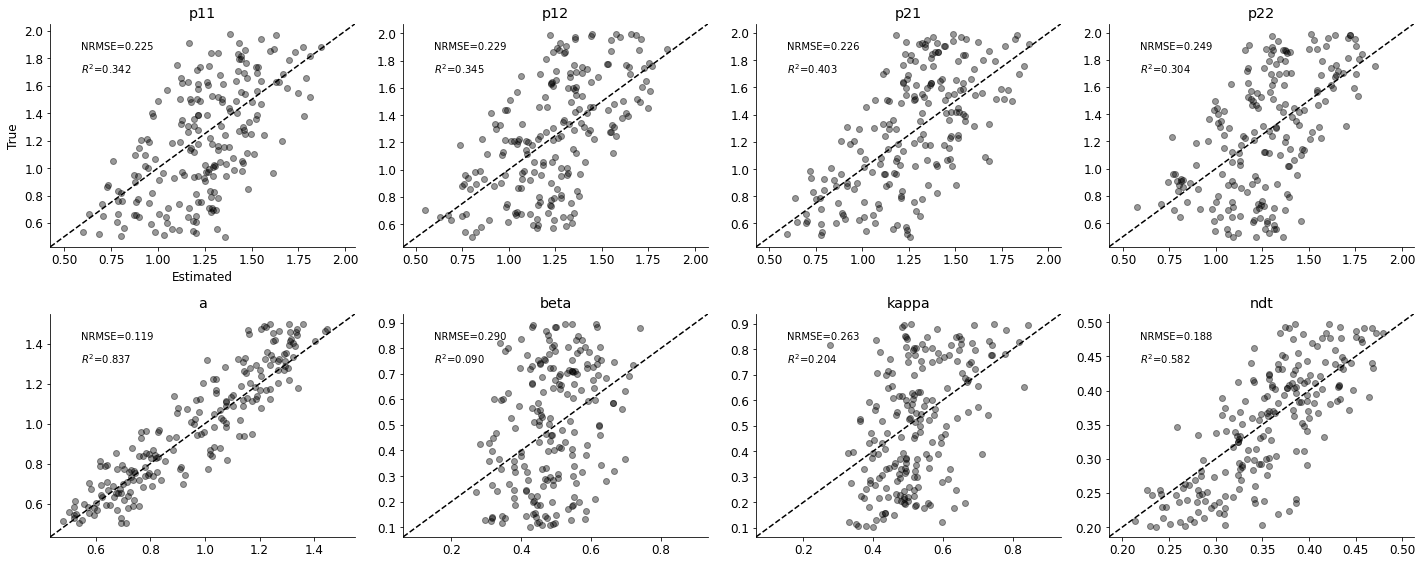

In [31]:
# Validate (quick and dirty)
p, x = trainer._forward_inference(200, 250)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)
true_vs_estimated(p, param_means, ['p11', 'p12', 'p21', 'p22', 'a', 'beta', 'kappa', 'ndt'], figsize=(20,8))

In [11]:
trainer.checkpoint = tf.train.Checkpoint(optimizer=trainer.optimizer, model=trainer.network)
trainer.manager = tf.train.CheckpointManager(trainer.checkpoint, "checkpt/", max_to_keep=2)
trainer.checkpoint_path = "checkpt/"
trainer.manager.save()

'checkpt/ckpt-1'

In [30]:
l = losses.values()

TypeError: 'dict_values' object is not subscriptable

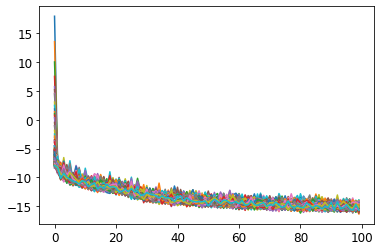

In [27]:
plt.plot(l)

In [45]:
p, x = trainer._forward_inference(1, 250)
param_samples = trainer.network.sample(x, n_samples=200)

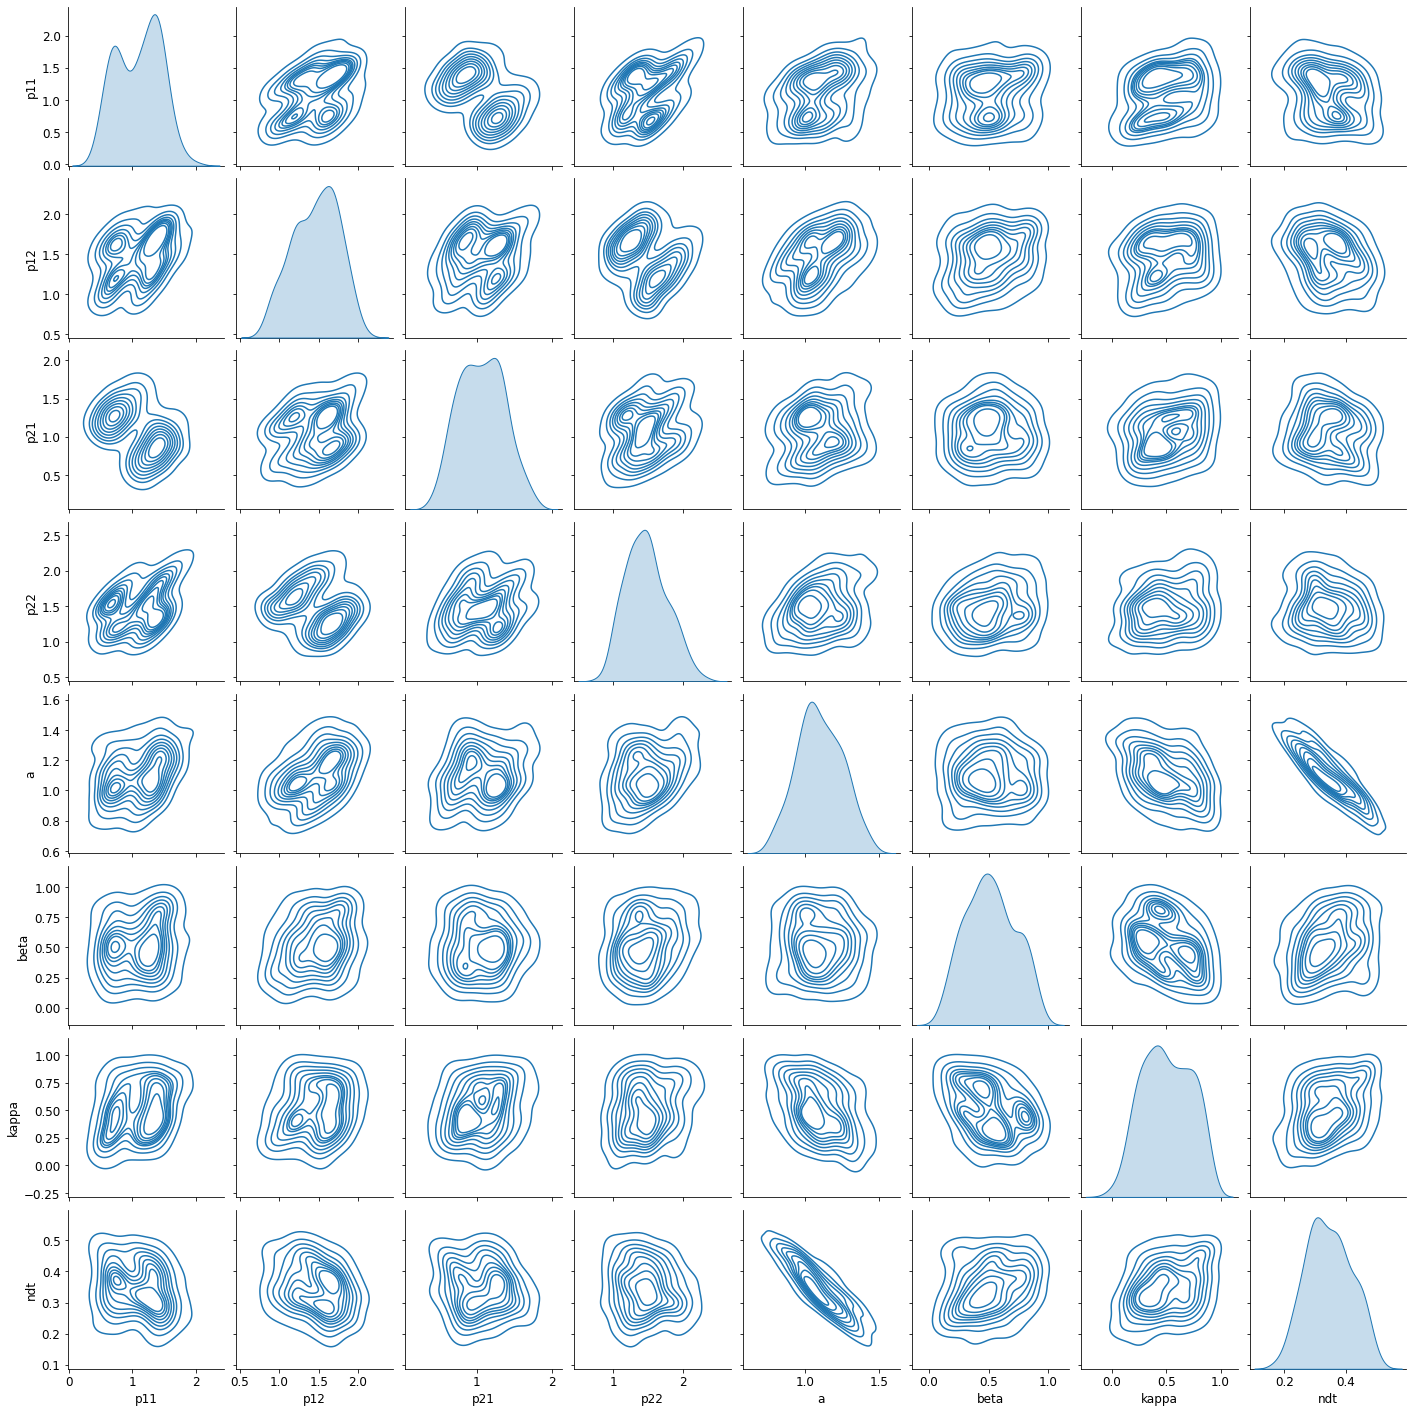

In [54]:
sns.pairplot(pd.DataFrame(param_samples, columns=['p11', 'p12', 'p21', 'p22', 'a', 'beta', 'kappa', 'ndt']), kind="kde")